- Import the pandas library.
- Use pandas to import the file train.csv as train.
- Use pandas to import the file test.csv as holdout.
- Display the first few lines of the test dataframe.

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

## Preprocessing the data

- Use the %load magic command to load the contents of functions.py into a notebook cell and read through the functions you have imported.
- Create a new function, which:
     - Accepts a dataframe parameter
    - Applies the process_missing(), process_age(), process_fare(), process_titles(), and process_cabin() functions to the dataframe
    - Applies the create_dummies() function to the "Age_categories", "Fare_categories","Title", "Cabin_type", and "Sex" columns.
    - Returns the processed dataframe
- Apply the newly create function on the train and holdout dataframes

In [7]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [8]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)

## Exploring the data

- Review the data dictionary and variable notes for the Titanic competition on Kaggle's website to familiarize yourself with the SibSp and Parch columns.
- Use pandas and matplotlib to explore those two columns. You might like to try:
    - Inspecting the type of the columns
    - Using histograms to view the distribution of values in the columns
    - Use pivot tables to look at the survival rate for different values of the columns
    - Find a way to combine the columns and look at the resulting distribution of values and survival rate
- Write a markdown cell explaining your findings.

In [9]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


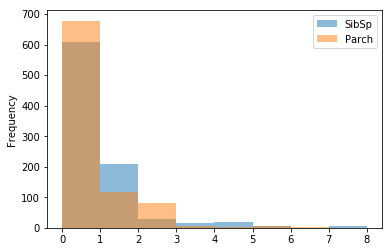

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()


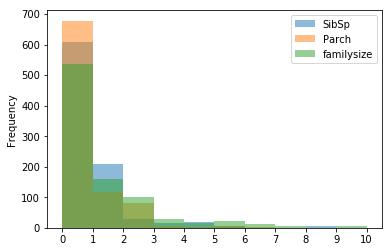

In [11]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

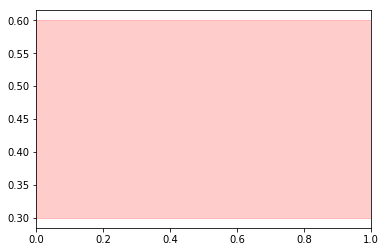

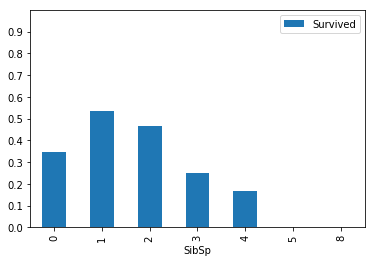

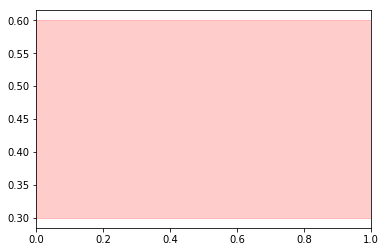

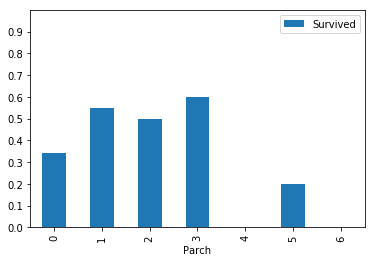

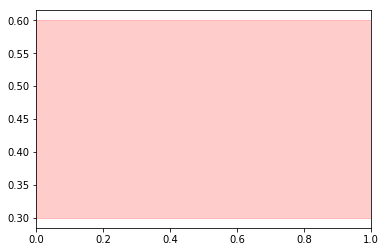

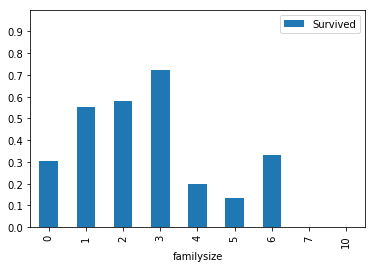

In [12]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.show()


The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.
The distribution of values in both columns is skewed right, with the majority of values being zero.
You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.
Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

## Engineering New Features

- Create a function, that:
    - Accepts a dataframe as input
    -  Adds a new column, isalone that has the value 0 if the passenger has one or more family members onboard, and 1 if the passenger has zero family members onboard.
    - Returns the new dataframe
- Apply the newly created function to the train and holdout dataframes.

In [20]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)